## Federated Learning architecture. Weighted metric average (WMA) of validation metrics.

## Pseudocode FL

Create a list with the number of data points per client  <br>
Create a variable for initial weights  <br>
Create a variable for the maximum number of rounds  <br>
Create an empty list for weighted average loss, accuracy and AUC for each round  <br>

For each round 'i' up to the maximum number of rounds:<br>
- Create an empty list for the weights<br>
- Create an empty list for validation loss of each client<br>
- Create an empty list for validation accuracy of each client<br>
- For each client:<br>
    - Train the model<br>
    - Get the model weights<br>
    - Save the weights in the list of weights<br>
    - Assign initial weights to the model<br>
    - Save the client accuracy, loss and AUC for validation<br>
- Save the average loss, accuracy and AUC of the clients for validation<br>
- Save the weighted average of the list of weights of the clients<br>
- Save the average loss, accuracy and AUC of the clients for test<br>
- Assign the weighted average weights to the model<br>
- Set the initial weights for the next round as the weighted average weights<br>

In [1]:
import os  # Operating system functionalities
import numpy as np  # Numerical operations and array handling
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Data visualization
import pickle  # Serialization and deserialization of Python objects
import random as rn  # Random number generator
import itertools  # Functions for creating iterators for efficient looping
from IPython.display import display  # For rendering in Jupyter Notebook

from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.preprocessing import MinMaxScaler  # Scaling features to a range

from tensorflow.keras.models import Sequential # For linear stacking of layers
# For creating densely-connected neural network layers, dropout regularization, and normalizing inputs in layers:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2 # For penalizing large weights
from tensorflow.keras.optimizers import Adam # For efficient gradient descent optimization

2024-01-29 15:37:54.342470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 15:37:54.475148: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Loading processed and curated dataset:

In [2]:
dfHeart = pd.read_csv("/srv/heart_ConditionalMeanImputation.csv")
dfHeart

,Sex_F,Sex_M,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_N,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,40,140.0,289.0,0,172,0.0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,49,160.0,180.0,0,156,1.0,1
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,37,130.0,283.0,0,98,0.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,48,138.0,214.0,0,108,1.5,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,54,150.0,195.0,0,122,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,45,110.0,264.0,0,132,1.2,1
914,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,68,144.0,193.0,1,141,3.4,1
915,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,57,130.0,131.0,0,115,1.2,1
916,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,57,130.0,236.0,0,174,0.0,1


Assigning the name of the originating hospital to each point in the dataset.

In [4]:
dfHeart["Name"]="name"
# Estimated (from raw data) slices for each hospital
dfHeart.loc[0:293,"Name"] = "hung" # Hungarian Institute of Cardiology, Budapest
# Author: Andras Janosi, M.D.
dfHeart.loc[293:477,"Name"] = "swit" # University Hospital (Zurich and Basel) Switzerland
# Author: William Steinbrunn, M.D. and Matthias Pfisterer, M.D respectively.
dfHeart.loc[477:615,"Name"] = "long" # V.A. Medical Center, Long Beach
# Author: Robert Detrano, M.D., Ph.D.
dfHeart.loc[615:766,"Name"] = "stat" # Statlog dataset (confidential source)
# Author: "King RD. Department of Statistics and Modelling Science, University of Strathclyde, Glasgow"
dfHeart.loc[766:918,"Name"] = "clev" # Cleveland Clinic Foundation
# Author: Robert Detrano, M.D., Ph.D.

Creating different clients with the sliced data.

In [5]:
# Each group is divided into train and test groups and scaled
# Creation of data_dict dictionary
data_dict = {}

groups = dfHeart.groupby('Name')

for name, group in groups:
    X = group.drop(['HeartDisease', 'Name'], axis=1)
    y = group['HeartDisease']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    
    # Scaling the data
    scaler = MinMaxScaler()
    scaler = scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # Filling data_dict dictionary
    data_dict[name] = {
      'X_train': X_train,
      'X_test': X_test,
      'y_train': y_train,
      'y_test': y_test
  }

In [6]:
n_i = [len(data_dict[name]['X_train']) for name in data_dict.keys()]
n_i

[114, 219, 103, 113, 138]

In [7]:
for i, group in enumerate(groups):
    name = group[0]
    print(name)

clev
hung
long
stat
swit


Building the optimal ANN architecture, previously estimated.

In [5]:
# Create the model
model = Sequential()

shape = data_dict[list(data_dict.keys())[0]]['X_train'].shape[1]

# Input layer
model.add(Dense(units=256, input_shape=(shape,), activation="relu", kernel_regularizer=l1_l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Hidden layers
model.add(Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Dense(units=128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Dense(units=32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

# Output layer
model.add(Dense(units=1, activation="sigmoid"))

# Compile the model
model.compile(optimizer= Adam(learning_rate=0.001),
              loss="binary_crossentropy", 
              metrics=["accuracy", "AUC"])

2024-01-16 22:44:26.258751: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-01-16 22:44:26.258850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2024-01-16 22:44:26.259496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def ave_weights(n_i,listOfWeights):
    """
    Aggregation function

   :param list n_i: Number of samples for each client
   :param list listOfWeights: Weights for each client
   :return: Final weighted average for global model
    """
    N = sum(n_i) # total number of samples of all clients
    # initial weights of global model, set to zero
    ave_weights = listOfWeights[0]
    ave_weights = [i * 0 for i in ave_weights]
    # loop whose range is number of clients
    for j in range(len(n_i)):
        # receive weights from clients
        rec_weight = listOfWeights[j]
        # multiply the client weights by number of local data samples in client local data
        rec_weight =  [i * n_i[j] for i in rec_weight]
        # divide the weights by total number of samples of all clients
        rec_weight =  [i / N for i in rec_weight]
        # sum the weights of new client with the prior
        ave_weights = [x + y for x, y in zip(ave_weights,rec_weight)]
    return ave_weights

In [7]:
def weighted_mean(n_i, metric_list):
    """
    Calculate the weighted mean of an evaluation metric.

    :param list n_i: Number of samples for each client
    :param list metric_list: List of evaluation metric values for each client
    :return: Weighted mean of the evaluation metric
    """
    total_samples = sum(n_i)  # Total number of samples of all clients
    weighted_metric_sum = 0.0

    for j in range(len(n_i)):
        weighted_metric_sum += metric_list[j] * n_i[j]

    weighted_mean = weighted_metric_sum / total_samples
    return weighted_mean

-  Select a maximum number of rounds, leaving a validation set for each dataset.
-  Analyze the error, accuracy and AUC of the resulting model for each round in the validation of each dataset.
-  Calculate the weighted average of the error/accuracy for each round. In other words, for round i, we will have different error and accuracy values for each dataset. You can aggregate them (weighted based on the number of data points) and obtain the weighted average of the error and/or accuracy.

Initialization of empty lists of metrics for validation.

In [8]:
loss_val_round = []
acc_val_round = []
AUC_val_round = []

Running the rounds.

In [9]:
# List with number of samples for each client
n_i = [len(data_dict[name]['X_train']) for name in data_dict.keys()]

# Get initial weights from created model before loop
initial_weights = model.get_weights()

# Maximum number of rounds n_times
n_times = 100

for i in range(1,n_times+1):
    # To get the initial weights:
    save_weights = list()
    # To generate weights for each client
    acc_val = []
    loss_val = []
    AUC_val = []
    for name in data_dict.keys():
        # Train client:
        X_train_np = np.array(data_dict[name]['X_train'])
        y_train_np = np.array(data_dict[name]['y_train'])
        history = model.fit(X_train_np,y_train_np, epochs=38, batch_size=14,validation_split=0.15, verbose=0)
        # Obtain client weights:
        weights_client = model.get_weights()
        # Save weights:
        save_weights.append(weights_client)
        model.set_weights(initial_weights)
        acc_val.append(history.history['val_accuracy'][-1])
        loss_val.append(history.history['val_loss'][-1])
        AUC_val.append(history.history['val_auc'][-1])
    # Saving weighted metric average for validation
    acc_val_round.append(weighted_mean(n_i,acc_val))
    loss_val_round.append(weighted_mean(n_i,loss_val))
    AUC_val_round.append(weighted_mean(n_i,AUC_val))
    
    # Aggregate the weights obtained with each client using an aggregation function that performs a weighted average:
    avg_weights = ave_weights(n_i,save_weights) # use of aggregation function
    model.set_weights(avg_weights)
    initial_weights = avg_weights

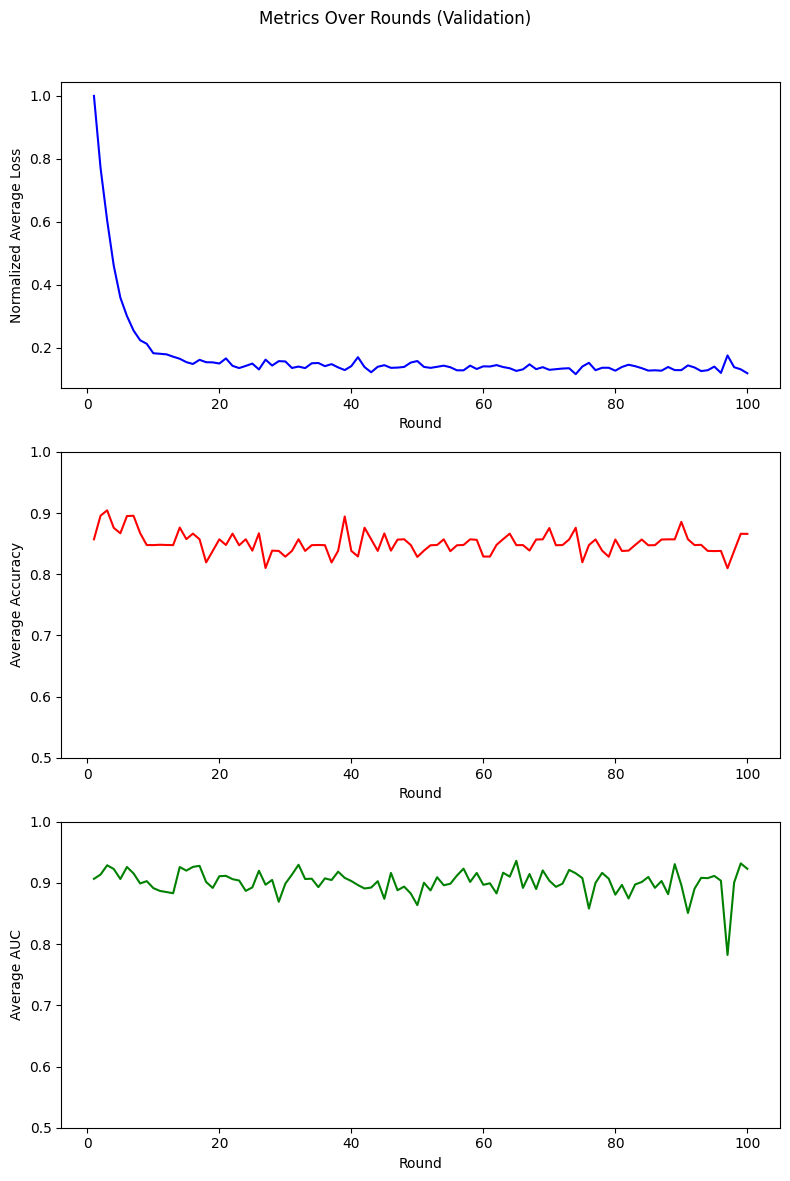

In [10]:
# Create figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# Convert the list to a NumPy array
loss_val_round_np = np.array(loss_val_round)

# Plot the average loss on the first subplot
ax1.plot(range(1, n_times + 1), loss_val_round_np / max(loss_val_round_np), label='Normalized Average Loss', color='blue')
ax1.set_xlabel('Round')
ax1.set_ylabel('Normalized Average Loss')
ax1.tick_params(axis='y')

# Plot the average accuracy on the second subplot
ax2.plot(range(1, n_times + 1), acc_val_round, label='Average Accuracy', color='red')
ax2.set_xlabel('Round')
ax2.set_ylabel('Average Accuracy')
ax2.tick_params(axis='y')
ax2.set(ylim=(0.5, 1))

# Plot the average AUC on the third subplot
ax3.plot(range(1, n_times + 1), AUC_val_round, label='Average AUC', color='green')
ax3.set_xlabel('Round')
ax3.set_ylabel('Average AUC')
ax3.tick_params(axis='y')
ax3.set(ylim=(0.5, 1))

# Set the title
plt.suptitle('Metrics Over Rounds (Validation)')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()

Once you have that weighted average for validation, select the optimal number of rounds that need to be repeated for the FL architecture.

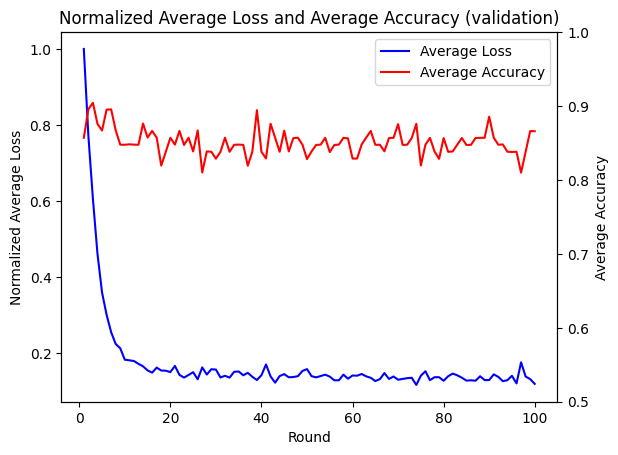

In [11]:
# Create figure and axes
fig, ax1 = plt.subplots()

# Convert the list to a NumPy array
loss_val_round_np = np.array(loss_val_round)

# Plot the average loss on the left y-axis

ax1.plot(range(1, n_times + 1), loss_val_round_np/max(loss_val_round_np), label='Average Loss', color='blue')
# Explica que aquí no es la loss lo que pones en el plot, si no la versión normalizada
ax1.set_xlabel('Round')
ax1.set_ylabel('Normalized Average Loss')
ax1.tick_params(axis='y')

# Create a twin axes on the right side
ax2 = ax1.twinx()

ax2.plot(range(1, n_times + 1), acc_val_round, label='Average Accuracy', color='red')
ax2.set_ylabel('Average Accuracy')
ax2.tick_params(axis='y')
ax2.set(ylim=(0.5, 1))

# Set the title
plt.title('Normalized Average Loss and Average Accuracy (validation)')

# Add legends
lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
plt.legend(lines, [line.get_label() for line in lines])

# Display the plot
plt.show()

In [12]:
# The best equilibrium between acc_val_round and loss_val_round is found at the round 32
max_acc_round = np.argmax(acc_val_round) + 1
max_acc_round

3

In [13]:
optim_acc = acc_val_round[max_acc_round-1]
optim_loss = loss_val_round[max_acc_round-1]
print("optim_acc:", optim_acc)
print("optim_loss:", optim_loss)

optim_acc: 0.9044253529419545
optim_loss: 1.9600515535651684


Repeat the process without using validation (i.e., now we do not leave data aside for validation since validation has already been done previously).

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=256, input_shape=(shape,), activation="relu", kernel_regularizer=regularizers.l1_l2(0.01)))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=128, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=1, activation="sigmoid"))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss="binary_crossentropy", 
                metrics=["accuracy", "AUC"])

Initialization of empty lists of metrics for test and the optim weigths.

In [ ]:
acc_test_round = [[] for _ in range(len(data_dict))] 
loss_test_round = [[] for _ in range(len(data_dict))]
AUC_test_round = [[] for _ in range(len(data_dict))]
optim_weights = []

In [ ]:
# Get initial weights from created model before loop
initial_weights = model.get_weights()

# Repeat n_times train clients data, average their weights to set on global model and save it
n_times = 50
for i in range(1,n_times+1):
    
    # Get the initial weights:
    save_weights = list()
    
    # Generate weights for each client
    for name in data_dict.keys():
        # Train client:
        X_train_np = np.array(data_dict[name]['X_train'])
        y_train_np = np.array(data_dict[name]['y_train'])
        model.fit(X_train_np, y_train_np, epochs=14, batch_size=38,verbose=0) 
        # Obtain client weights:
        weights_client = model.get_weights()
        # Save weights:
        save_weights.append(weights_client)
        model.set_weights(initial_weights)

    # Aggregate the weights obtained with each client using an aggregation function that performs a weighted average:
    avg_weights = ave_weights(n_i,save_weights) # use of aggregation function
    model.set_weights(avg_weights)
    for idx, name in enumerate(data_dict.keys()):
        X_test_np = np.array(data_dict[name]['X_test'])
        y_test_np = np.array(data_dict[name]['y_test'])
        score_test = model.evaluate(X_test_np, y_test_np, verbose = 0)
        # Saving metrics for test:
        loss_test_round[idx].append(score_test[0])
        acc_test_round[idx].append(score_test[1])
        AUC_test_round[idx].append(score_test[2])
    initial_weights = avg_weights

    # Saving weights for optim round
    if i == max_acc_round:
        optim_weights = avg_weights

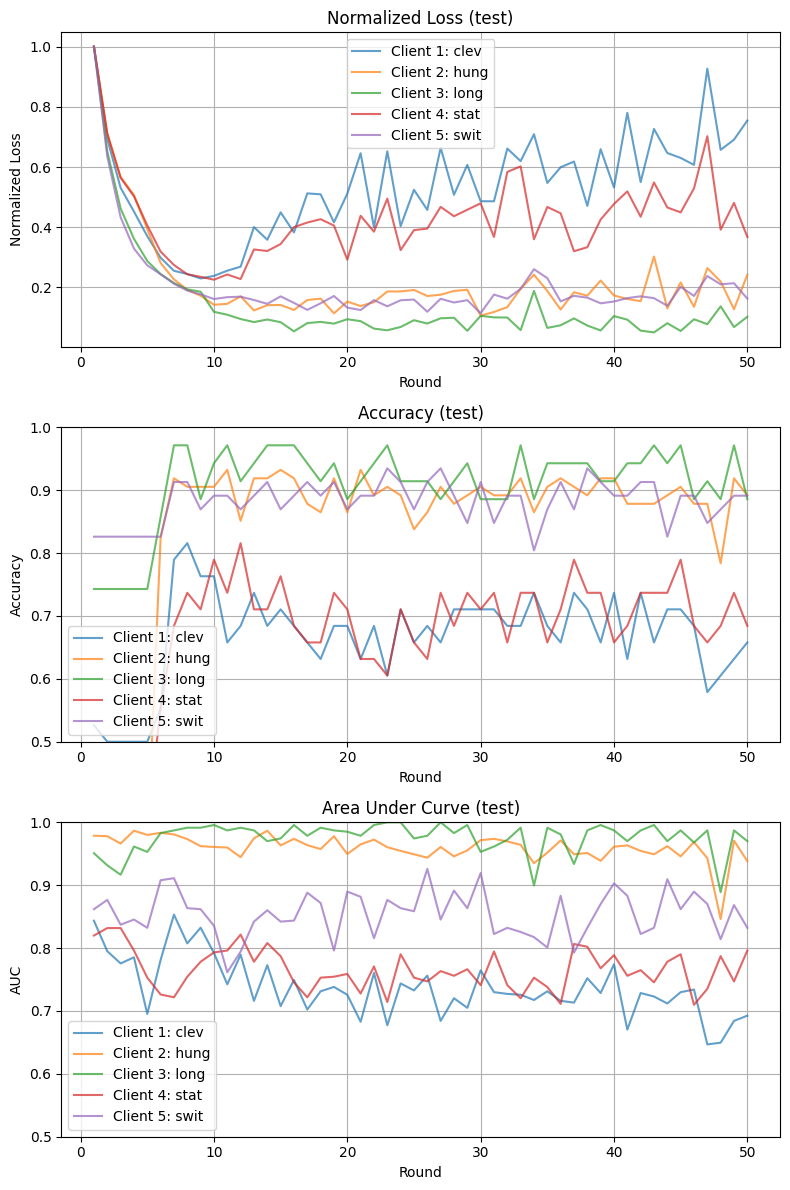

In [ ]:
loss_test_round_np = np.array(loss_test_round)
# Create a figure with three subplots (one row and three columns)
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8, 12))

# Iterate over the lists of loss, accuracy, and AUC of each client
for i, group in enumerate(groups):
    name = group[0]
    client_loss = loss_test_round_np[i]
    client_accuracy = acc_test_round[i]
    client_auc = AUC_test_round[i]
    
    # Subplot 1: Loss Curve
    ax1.plot(range(1, n_times + 1), client_loss / max(client_loss), label= f'Client {i+1}: {name}', alpha=0.7)

    # Subplot 2: Accuracy Curve
    ax2.plot(range(1, n_times + 1), client_accuracy, label= f'Client {i+1}: {name}', alpha=0.7)

    # Subplot 3: AUC Curve
    ax3.plot(range(1, n_times + 1), client_auc, label= f'Client {i+1}: {name}', alpha=0.7)

# Add labels and titles to subplots
ax1.set_xlabel('Round')
ax1.set_ylabel('Normalized Loss')
ax1.set_title('Normalized Loss (test)')
#ax1.set(xlim=(0, 25))
ax1.grid()
ax1.legend()

ax2.set_xlabel('Round')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy (test)')
# ax2.set(xlim=(0, 25))
ax2.set(ylim=(0.5, 1))
ax2.grid()
ax2.legend()

ax3.set_xlabel('Round')
ax3.set_ylabel('AUC')
ax3.set_title('Area Under Curve (test)')
# ax3.set(xlim=(0, 25))
ax3.set(ylim=(0.5, 1))
ax3.grid()
ax3.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Combine the lists of lists into a dictionary
data_to_save = {
    'acc_val_round': acc_val_round,
    'loss_val_round': loss_val_round,
    'AUC_val_round': AUC_val_round,
    'acc_test_round': acc_test_round,
    'loss_test_round': loss_test_round,
    'AUC_test_round': AUC_test_round,
    'optim_weights': optim_weights
}

# Save the combined data using Pickle
with open('results_Test_FL_WMA_v4.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)